# MADE Demo

Autoregressive density estimation for MNIST using masked FFNN (MADE).

In [1]:
import sys
import argparse
import pprint
import pathlib
import numpy as np
import torch
import json
from tqdm import tqdm
from collections import OrderedDict, defaultdict

from torch.distributions import Bernoulli

import dgm
from dgm.conditional import MADEConditioner
from dgm.likelihood import FullyFactorizedLikelihood, AutoregressiveLikelihood
from dgm.opt_utils import get_optimizer, ReduceLROnPlateau
from utils import load_mnist, Batcher



Organise some hyperparameters

In [2]:
from collections import namedtuple

Config = namedtuple(
    "Config", 
    ['seed', 'device', 'batch_size', 'data_dir', 
     'height', 'width', 'input_dropout',
    'hidden_sizes', 'num_masks', 'resample_mask_every', 'll_samples',
    'epochs', 'opt', 'lr', 'momentum', 'l2_weight', 'patience', 'early_stopping'])

args = Config(
    seed=42,
    device='cuda:0',
    batch_size=64,
    data_dir='./data',
    height=28,
    width=28,    
    input_dropout=0.,
    hidden_sizes=[500, 500],
    num_masks=10,
    resample_mask_every=20,
    ll_samples=10,
    epochs=100,
    opt='adam',
    lr=1e-4,
    momentum=0.,
    l2_weight=1e-4,
    patience=10,  
    early_stopping=10,    
)

We like reproducibility

In [3]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

Load data

In [4]:
train_loader, valid_loader, test_loader = load_mnist(
    args.batch_size, 
    save_to='{}/std/{}x{}'.format(args.data_dir, args.height, args.width),
    height=args.height, 
    width=args.width)

Build a model

\begin{align}
    P(x) &= \prod_{i=1}^{|x|} \text{Bern}(x_i|\underbrace{f(x_{<i})}_{\text{MADE}})
\end{align}

For that we need a *conditioner*
* the part that maps prefixes into Bernoulli parameters

and an *autoregressive likelihood*
* the part that combines the Bernoulli factors



In [5]:
x_size = args.width * args.height
device = torch.device(args.device) 
made = MADEConditioner(
    input_size=x_size,  # our only input to the MADE layer is the observation
    output_size=x_size * 1,  # number of parameters to predict
    context_size=0,  # we do not have any additional inputs
    hidden_sizes=args.hidden_sizes,  
    num_masks=args.num_masks
)        
model = AutoregressiveLikelihood(
    event_size=x_size,  # size of observation
    dist_type=Bernoulli, 
    conditioner=made
).to(device)

print("\n# Architecture")
print(model)


# Architecture
AutoregressiveLikelihood(
  (conditioner): MADEConditioner(
    (_made): MADE(
      (hidden_activation): ReLU()
      (net): Sequential(
        (0): MaskedLinear(in_features=784, out_features=500, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=500, out_features=500, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=500, out_features=784, bias=True)
      )
    )
  )
)


Let's configure the optimiser

In [6]:
print("\n# Optimizer")
opt = get_optimizer(args.opt, model.parameters(), args.lr, args.l2_weight, args.momentum)
scheduler = ReduceLROnPlateau(
    opt, 
    factor=0.5, 
    patience=args.patience,
    early_stopping=args.early_stopping,
    mode='min', threshold_mode='abs')
print(opt)


# Optimizer
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.0001
)


Some helper code for batching MNIST digits

In [7]:
def get_batcher(data_loader):
    batcher = Batcher(
        data_loader, 
        height=args.height, 
        width=args.width, 
        device=torch.device(args.device), 
        binarize=True, 
        num_classes=10,
        onehot=True
    )
    return batcher

Helper code for validating a model

In [8]:
def validate(batcher, args, model,
    optimizer=None, scheduler=None, writer=None, name='dev'): 
    """
    :return: stop flag, dict 
        NLL can be found in the dict
    """

    if args.num_masks == 1:
        resample_mask = False
        num_samples = 1
    else:  # ensemble
        resample_mask = True
        num_samples = args.ll_samples    
    
    with torch.no_grad():
        model.eval()
        print_ = defaultdict(list)
        nb_instances = 0.
        for x_mb, y_mb in batcher:
            # [B, H*W]
            x_mb = x_mb.reshape(-1, args.height * args.width)            
            # [B, 10]
            made_inputs = x_mb 
            # [B, H*W]
            p_x = model(
                inputs=None, 
                history=x_mb, 
                num_samples=num_samples, resample_mask=resample_mask
            )
            # [B]            
            nll = -p_x.log_prob(x_mb).sum(-1)
            # accumulate metrics
            print_['NLL'].append(nll.sum().item())
            nb_instances += x_mb.size(0)

        return_dict = {k: np.sum(v) / nb_instances for k, v in print_.items()}
        if writer:            
            writer.add_scalar('%s/NLL' % name, return_dict['NLL'])    

        stop = False
        if scheduler is not None:
            stop = scheduler.step(return_dict['NLL'])
                
        return stop, return_dict  

Main training loop

In [9]:
print("\n# Training")

#from tensorboardX import SummaryWriter        
#writer = SummaryWriter(args.logdir)
writer = None
step = 1

for epoch in range(args.epochs):

    iterator = tqdm(get_batcher(train_loader))

    for x_mb, y_mb in iterator:
        # [B, H*W]
        x_mb = x_mb.reshape(-1, args.height * args.width)
        # [B, 10]
        context = None
        model.train()
        opt.zero_grad()

        if args.num_masks == 1:
            resample_mask = False
        else:  # training with variable masks
            resample_mask = args.resample_mask_every > 0 and step % args.resample_mask_every == 0

        # [B, H*W] 
        noisy_x = torch.where(
            torch.rand_like(x_mb) > args.input_dropout, x_mb, torch.zeros_like(x_mb)
        )
        p_x = model(
            inputs=context,
            history=noisy_x,
            resample_mask=resample_mask
        )
        # [B, H*W]
        ll_mb = p_x.log_prob(x_mb)
        # [B]
        ll = ll_mb.sum(-1)

        loss = -(ll).mean()
        loss.backward()
        opt.step()    


        display = OrderedDict()
        display['0s'] = '{:.2f}'.format((x_mb == 0).float().mean().item())
        display['1s'] = '{:.2f}'.format((x_mb == 1).float().mean().item())
        display['NLL'] =  '{:.2f}'.format(-ll.mean().item())     

        if writer:            
            writer.add_scalar('training/LL', ll)
            #writer.add_image('training/posterior/sample', z.mean(0).reshape(1,1,-1) * 255)

        iterator.set_postfix(display, refresh=False)
        step += 1

    stop, dict_valid = validate(get_batcher(valid_loader), args, model, opt, scheduler, 
        writer=writer, name="dev")

    if stop:
        print('Early stopping at epoch {:3}/{}'.format(epoch + 1, args.epochs))
        break

    print('Epoch {:3}/{} -- '.format(epoch + 1, args.epochs) + \
          ', '.join(['{}: {:4.2f}'.format(k, v) for k, v in sorted(dict_valid.items())]))

  0%|          | 0/860 [00:00<?, ?it/s]


# Training


  0%|          | 3/860 [00:00<00:32, 26.29it/s, 0s=0.87, 1s=0.13, NLL=273.84]

Epoch   1/3 -- NLL: 212.83


  0%|          | 2/860 [00:00<01:03, 13.56it/s, 0s=0.87, 1s=0.13, NLL=239.57]

Epoch   2/3 -- NLL: 202.53


100%|██████████| 860/860 [00:35<00:00, 26.11it/s, 0s=0.87, 1s=0.13, NLL=228.71]


Epoch   3/3 -- NLL: 195.46


Let's visualise samples

In [10]:
from matplotlib import pyplot as plt

def visualize_made(batcher: Batcher, args, model, N=4, writer=None, name='dev'): 

    assert N <= args.batch_size, "N should be no bigger than a batch"
    with torch.no_grad():
        model.eval()        
    
        plt.figure(figsize=(2*N, 2*N))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)        
        
        # Some visualisations
        for x_mb, y_mb in batcher:
            
            # [B, H*W]
            x_mb = x_mb.reshape(-1, args.height * args.width)
            x_mb = x_mb[:N]
            # [B, 10]
            context = None
            
            p_x = model(inputs=None, history=x_mb, resample_mask=False)
            # [B, H*W]
            ll = p_x.log_prob(x_mb)
            prob = torch.exp(ll)

            # reconstruct bottom half of N instances
            x_rec = model.sample(inputs=None, history=x_mb, start_from=args.height * args.width // 2)
            # sample N instances
            x_sample = model.sample(
                inputs=None,
                history=torch.zeros(
                    [N, args.height * args.width], 
                    device=torch.device(args.device), 
                    dtype=torch.float32
                ),
                start_from=0
            )
            for i in range(N):
                plt.subplot(4, N, 0*N + i + 1)
                plt.imshow(x_mb[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("x%d" % (i + 1))

                plt.subplot(4, N, 1*N + i + 1)
                plt.imshow(prob[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("prob%d" % (i + 1))
                
                plt.subplot(4, N, 2*N + i + 1)                
                plt.axhline(y=args.height//2, c='red', linewidth=1, ls='--')
                plt.imshow(x_rec[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("rec%d" % (i + 1))
                
                plt.subplot(4, N, 3*N + i + 1)
                plt.imshow(x_sample[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("sample%d" % (i + 1))
                
            break

    plt.show()

A few reconstructions for the validation set as well as samples from the autoregressive likelihood

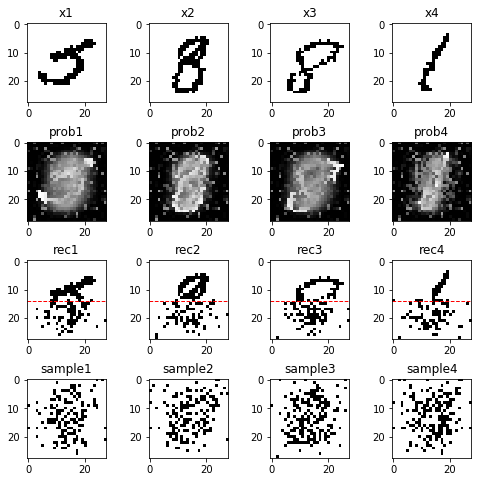

In [11]:
visualize_made(get_batcher(valid_loader), args, model)